<a href="https://colab.research.google.com/github/wallace91x/ecommerce-churn-mvp-machine-learning/blob/main/Machine_Learning_%26_Analytics_Wallace_Conceicao(40530010055_20250_01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning & Analytics

**Nome:** Wallace de Lima da Silva Conceicao

**Matrícula:** 4052024002302

**Dataset:** [Ecommerce Customer Churn Analysis and Prediction](https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download)

# Descrição do Problema

Este projeto tem como objetivo prever churn de clientes em e-commerce (classificação binária supervisionada), a partir de variáveis de comportamento de compra, engajamento digital e fricções de atendimento. O alvo é Churn (0 = ativo/retido, 1 = churn).

A motivação é priorizar ações de retenção (cupons, reativação, atendimento), reduzindo perda de receita e aumentando LTV.

# Premissas Consideradas

* O dataset representa clientes de um e-commerce em uma janela recente; a coluna Churn já vem rotulada (0/1).

* Identificadores (ex.: CustomerID) não serão usados como features.

* Há variáveis numéricas e categóricas (ex.: HourSpendOnApp, OrderCount, DaySinceLastOrder, Complain, SatisfactionScore, PreferredPaymentMode, CityTier).

* Pode haver dados faltantes em algumas colunas.

* Sem vazamento: toda transformação será ajustada apenas no treino (via Pipeline).

* Execução reprodutível em Colab, com carga por URL (sem configurações locais).

# Hipóteses do Problema

* Recência alta (DaySinceLastOrder) e baixa frequência (OrderCount) aumentam o churn.

* Fricções (Complain) e satisfação baixa (SatisfactionScore) elevam o churn.

* Engajamento no app (HourSpendOnApp, NumberOfDeviceRegistered) reduz o churn.

* Incentivos (CouponUsed, CashbackAmount) podem mitigar churn, com efeito não linear.

* Contexto (CityTier, PreferredPaymentMode) influencia diferenças de risco.



# Tipo de Problema

* Classificação binária supervisionada (prever Churn 0/1).

* Avaliação focada em Recall/Sensibilidade (priorizar captura de churners) com Especificidade de controle; também Acurácia, Precisão, ROC e PR.

* Validação com split estratificado e cross-validation; comparação de KNN, Árvore de Decisão, Naive Bayes e SVM.

# Seleção de Dados

* Usaremos um dataset público de churn em e-commerce (versão completa carregada via URL no notebook) e a amostra fornecida para alinhamento inicial.

*  arquivo possui colunas típicas de RFM/engajamento/fricção e identificadores.

* Conversões previstas: padronização de nomes, casting do alvo para 0/1, exclusão de identificadores, tratamento de NAs e categorias raras.

# Etapa 1 - Instalação inicial


In [27]:

!pip -q install kagglehub openpyxl
import random, os, sys, platform, numpy as np, pandas as pd, sklearn
import os
from pathlib import Path
import kagglehub

SEED = 42
pd.set_option('display.max_columns', None)
random.seed(SEED)
np.random.seed(SEED)

print("Reprodutibilidade:")
print(f"- SEED: {SEED}")
print("\nAmbiente:")
print(f"- Python: {sys.version.split()[0]}")
print(f"- Platform: {platform.platform()}")
print(f"- numpy: {np.__version__}")
print(f"- pandas: {pd.__version__}")
print(f"- scikit-learn: {sklearn.__version__}")

Reprodutibilidade:
- SEED: 42

Ambiente:
- Python: 3.12.11
- Platform: Linux-6.6.97+-x86_64-with-glibc2.35
- numpy: 2.0.2
- pandas: 2.2.2
- scikit-learn: 1.6.1


# Etapa 2 - Download dataset

In [28]:
# Baixando a versão do dataset do Kaggle
DATASET_SLUG = "ankitverma2010/ecommerce-customer-churn-analysis-and-prediction"
data_dir = Path(kagglehub.dataset_download(DATASET_SLUG))
print("Diretório do dataset:", data_dir)
print("Arquivos no diretório:", os.listdir(data_dir))

# Apontando para o arquivo Excel
DATA_FILE = data_dir / "E Commerce Dataset.xlsx"
if not DATA_FILE.exists():
    xlsx_files = [f for f in os.listdir(data_dir) if f.lower().endswith(".xlsx")]
    assert xlsx_files, "Nenhum .xlsx encontrado; verifique o conteúdo do dataset."
    DATA_FILE = data_dir / xlsx_files[0]

print("Arquivo Excel selecionado:", DATA_FILE)


Using Colab cache for faster access to the 'ecommerce-customer-churn-analysis-and-prediction' dataset.
Diretório do dataset: /kaggle/input/ecommerce-customer-churn-analysis-and-prediction
Arquivos no diretório: ['E Commerce Dataset.xlsx']
Arquivo Excel selecionado: /kaggle/input/ecommerce-customer-churn-analysis-and-prediction/E Commerce Dataset.xlsx


# Etapa 3 - Leitura da aba “E Comm” e tratamento dos dados

In [29]:
# Lendo a pasta (aba) "E Comm"
SHEET_NAME = "E Comm"

df = pd.read_excel(DATA_FILE, sheet_name=SHEET_NAME, engine="openpyxl")

# Normalizando nomes de colunas
df.columns = (df.columns
                .str.strip()
                .str.lower()
                .str.replace(r'[^0-9a-z]+', '_', regex=True))

# Convertendo 'churn' para 0/1 (para variações)
assert 'churn' in df.columns, "Coluna 'churn' não encontrada na aba 'E Comm'."
if df['churn'].dtype == object:
    df['churn'] = (df['churn'].astype(str)
                             .str.strip()
                             .str.lower()
                             .isin(['1','true','yes','sim','churn'])).astype(int)
elif pd.api.types.is_bool_dtype(df['churn']):
    df['churn'] = df['churn'].astype(int)
else:
    df['churn'] = df['churn'].astype(float).round().clip(0,1).astype(int)

# Removendo identificadores que não entram como feature
for col in ['customer_id', 'id', 'client_id']:
    if col in df.columns:
        df = df.drop(columns=col)

# Limpeza básica
df = df.dropna(how='all').drop_duplicates()

# Sanidade do alvo
assert df['churn'].notna().all(), "Existem valores nulos em 'churn'."
assert set(df['churn'].unique()).issubset({0,1}), "'churn' não está binário."

print("Shape após leitura e limpeza:", df.shape)
df.head(8)


Shape após leitura e limpeza: (5630, 20)


,customerid,churn,tenure,preferredlogindevice,citytier,warehousetohome,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
5,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,Laptop & Accessory,2,Divorced,4,0,14.0,0.0,1.0,0.0,120.86
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,Mobile,2,Divorced,3,1,16.0,2.0,2.0,0.0,122.93


# Etapa 4 - Preparando X e Y

In [30]:
# Distribuição do alvo
print("Distribuição churn (0/1):")
print(df['churn'].value_counts().sort_index())
print(f"Taxa de churn ≈ {df['churn'].mean():.2%}")

# Missing e tipos
audit = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "%_missing": df.isna().mean().mul(100).round(2)
}).sort_values("%_missing", ascending=False)
display(audit.head(20))

# Separação de X e y (sem split ainda)
X = df.drop(columns='churn')
y = df['churn'].astype(int)

print("\nShapes — X:", X.shape, "| y:", y.shape)


Distribuição churn (0/1):
churn
0    4682
1     948
Name: count, dtype: int64
Taxa de churn ≈ 16.84%


,dtype,%_missing
daysincelastorder,float64,5.45
orderamounthikefromlastyear,float64,4.71
tenure,float64,4.69
ordercount,float64,4.58
couponused,float64,4.55
hourspendonapp,float64,4.53
warehousetohome,float64,4.46
customerid,int64,0.00
preferredlogindevice,object,0.00
churn,int64,0.00



Shapes — X: (5630, 19) | y: (5630,)


# Observações

A taxa de churn é ~16,84% (948 de 5.630), caracterizando desbalanceamento moderado. Acurácia isolada pode ser enganosa (um modelo que prevê “não churn” já acerta ~83%). Por isso, adotaremos divisão estratificada nas partições, baseline com DummyClassifier, e avaliaremos principalmente Recall/Sensibilidade (capturar churners), acompanhada de Especificidade, Precision–Recall e AUC-ROC. Para modelos que suportam, testaremos class_weight="balanced" e ajuste de limiar para otimizar o trade-off de negócios.

Há missing baixo (≈4–6%) nas variáveis daysincelastorder, orderamounthikefromlastyear, tenure, ordercount, couponused, hourspendonapp e warehousetohome. Esse nível é administrável: adotaremos imputação por mediana (robusta a outliers) e indicadores de ausência ao menos para as variáveis com mais faltas, pois a ausência pode conter informação (cliente novo, sem histórico, uso fora do app, etc.).

No pré-processamento, aplicaremos One-Hot Encoding às categóricas (handle_unknown="ignore"), com agregação de categorias raras quando necessário, e StandardScaler nas numéricas (requisito para KNN e SVM). Todo o fluxo será implementado em Pipeline/ColumnTransformer para evitar vazamento (ajuste apenas no treino) e garantir reprodutibilidade.

Hipóteses a validar na modelagem: recência maior e frequência menor tendem a elevar churn; tenure baixo/ausente pode sinalizar risco; engajamento no app reduz churn; incentivos (uso de cupom/variação de gasto vs. ano anterior) podem ajudar a reter, com efeito possivelmente não linear; distâncias logísticas maiores podem aumentar fricção. Próximo passo: executar o split estratificado e estabelecer o baseline, antes da comparação entre KNN, Árvore, Naive Bayes e SVM.

# Etapa 5 - Estratificação (60/20/20) e check

In [31]:


from sklearn.model_selection import train_test_split

def describe_partition(name, y_part):
    y_part = pd.Series(y_part)
    counts = y_part.value_counts().sort_index()
    rate = y_part.mean()
    print(f"{name:<12} -> n={len(y_part):>5} | churn=0: {counts.get(0,0):>5} | churn=1: {counts.get(1,0):>5} | taxa_churn={rate:6.2%}")

# 60/20/20: separacao amostra TESTE (20%), e validação com 25% do restante (25% de 80% = 20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,          # 25% de 80% = 20% do total
    stratify=y_trainval,
    random_state=SEED
)

describe_partition("Treino", y_train)
describe_partition("Validação", y_val)
describe_partition("Teste", y_test)


Treino       -> n= 3378 | churn=0:  2809 | churn=1:   569 | taxa_churn=16.84%
Validação    -> n= 1126 | churn=0:   937 | churn=1:   189 | taxa_churn=16.79%
Teste        -> n= 1126 | churn=0:   936 | churn=1:   190 | taxa_churn=16.87%


# Etapa 6 - Baseline (DummyClassifier) e métricas

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
)

def compute_metrics(y_true, y_pred, y_proba=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    out = {
        "Acurácia": accuracy_score(y_true, y_pred),
        "Precisão": precision_score(y_true, y_pred, zero_division=0),
        "Recall/Sensibilidade": recall_score(y_true, y_pred, zero_division=0),
        "Especificidade": specificity
    }
    if y_proba is not None:
        try:
            out["ROC AUC"] = roc_auc_score(y_true, y_proba)
        except Exception:
            out["ROC AUC"] = np.nan
    return out

# Baseline - estratégia estratificada mantém a distribuição de classes
dummy = DummyClassifier(strategy="stratified", random_state=SEED)
dummy.fit(X_train, y_train)

# Predições na validação
y_val_pred = dummy.predict(X_val)

y_val_proba = None
if hasattr(dummy, "predict_proba"):
    y_val_proba = dummy.predict_proba(X_val)[:, 1]

baseline_metrics = compute_metrics(y_val, y_val_pred, y_val_proba)
print("Métricas do Baseline (Validação):")
for k, v in baseline_metrics.items():
    print(f"- {k}: {v:.4f}")


Métricas do Baseline (Validação):
- Acurácia: 0.7087
- Precisão: 0.1472
- Recall/Sensibilidade: 0.1534
- Especificidade: 0.8207
- ROC AUC: 0.4871


# Observações
A estratificação funcionou: a taxa de churn ficou praticamente idêntica nas três partições
Treino ≈ 16,84% (569/3.378), Validação ≈ 16,79% (189/1.126), Teste ≈ 16,87% (190/1.126).

Isso é importante para avaliar modelos em distribuições consistentes com o todo.

O problema é desbalanceado (churn ~17%).
Por isso, acurácia isolada não é uma boa métrica de comparação.

Baseline com DummyClassifier(strategy="stratified") na validação:
Acurácia 0,7087
Precisão 0,1472
Recall 0,1534
Especificidade 0,8207
ROC AUC 0,4871.

Interpretação:

Acurácia relativamente alta decorre do desbalanceamento; não indica bom poder de predição.

Precisão e Recall próximos da taxa de churn mostram que o baseline acerta positivos quase “no acaso”.

Especificidade alta e Recall baixo indicam tendência a prever “não churn” com frequência.

ROC AUC < 0,5 confirma desempenho próximo ao aleatório.

Esse baseline estabelece o “piso” de desempenho: qualquer modelo útil deve aumentar, principalmente, Recall e ROC AUC, mantendo Especificidade em níveis aceitáveis.

Próximas decisões para a modelagem:

Usar métricas focadas no desbalanceamento: Recall, Precisão, Matriz de Confusão, ROC e PR.

Considerar class_weight="balanced" (quando suportado) e ajuste de limiar de decisão para melhorar Recall.

Manter split estratificado e avaliação final apenas no conjunto de teste.

# Etapa 7 - Imports e Definições das listas de colunas

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# (Re)definição robusta das listas a partir do df já higienizado
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'churn' in num_cols:
    num_cols.remove('churn')

cat_cols = df.select_dtypes(exclude=['number', 'bool']).columns.tolist()

print("num_cols:", num_cols)
print("cat_cols:", cat_cols)


num_cols: ['customerid', 'tenure', 'citytier', 'warehousetohome', 'hourspendonapp', 'numberofdeviceregistered', 'satisfactionscore', 'numberofaddress', 'complain', 'orderamounthikefromlastyear', 'couponused', 'ordercount', 'daysincelastorder', 'cashbackamount']
cat_cols: ['preferredlogindevice', 'preferredpaymentmode', 'gender', 'preferedordercat', 'maritalstatus']


# Etapa 8 - Construção do pré-processador (numéricas e categóricas)

In [34]:
# OneHot com agrupamento de categorias raras (>=1% da amostra de treino)

ohe = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    min_frequency=0.01,
    sparse_output=False  # se sua versão não suportar, use 'sparse=False'
)

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Ajustando o pré-processador somente no TREINO (evita vazamento)
preprocess.fit(X_train)

# Mostrando quantas features resultam após o pré-processamento
n_out = preprocess.get_feature_names_out().shape[0]
print(f"Total de features após o pré-processamento: {n_out}")
print("Exemplos de nomes de features:", preprocess.get_feature_names_out()[:10])


Total de features após o pré-processamento: 42
Exemplos de nomes de features: ['customerid' 'tenure' 'citytier' 'warehousetohome' 'hourspendonapp'
 'numberofdeviceregistered' 'satisfactionscore' 'numberofaddress'
 'complain' 'orderamounthikefromlastyear']


# Etapa 9 - Pré-transformação de amostras (verificação) e shapes

In [35]:
Xtr_pp = preprocess.transform(X_train)
Xva_pp = preprocess.transform(X_val)
Xte_pp = preprocess.transform(X_test)

print("Shapes pós-pré-processamento:")
print("  Treino:", Xtr_pp.shape)
print("  Validação:", Xva_pp.shape)
print("  Teste:", Xte_pp.shape)


Shapes pós-pré-processamento:
  Treino: (3378, 42)
  Validação: (1126, 42)
  Teste: (1126, 42)


# Observações

Os três conjuntos ficaram com a mesma dimensionalidade (42 features):
Treino (3378, 42) | Validação (1126, 42) | Teste (1126, 42).
Isso confirma que o ColumnTransformer aplicou exatamente o mesmo mapeamento em todas as partições (one-hot com as categorias aprendidas no treino + indicadores de missing + scaling), sem alterar ordem/quantidade de colunas.

O número 42 reflete a expansão de features:

Numéricas ⇒ imputação por mediana + flag de missing (+ StandardScaler não muda a contagem).

Categóricas ⇒ One-Hot com agregação de raras (≥1%).
O resultado é um espaço de atributos único e estável para todos os modelos.

Conclusão: a preparação está consistente e sem vazamento (o fit do pré-processamento foi feito apenas no treino). Agora, podemos avançar para a modelagem (KNN, Árvore, Naive Bayes e SVM) com segurança.

# Etapa 10 - Imports, CV e funções de avaliação

In [36]:


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve, auc)
import matplotlib.pyplot as plt


CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)  # CV somente no TREINO

def compute_metrics(y_true, y_pred, y_proba=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    specificity = tn / (tn + fp) if (tn + fp) else np.nan
    out = {
        "Acurácia": accuracy_score(y_true, y_pred),
        "Precisão": precision_score(y_true, y_pred, zero_division=0),
        "Recall/Sensibilidade": recall_score(y_true, y_pred, zero_division=0),
        "Especificidade": specificity
    }
    if y_proba is not None:
        try:
            out["ROC AUC"] = roc_auc_score(y_true, y_proba)
        except Exception:
            out["ROC AUC"] = np.nan
    return out

def plot_roc_curves(models_probas, y_true, title="ROC (validação)"):
    plt.figure(figsize=(7,5))
    for name, y_proba in models_probas.items():
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    plt.plot([0,1], [0,1], 'k--', alpha=.5)
    plt.xlabel("FPR (1 - Especificidade)")
    plt.ylabel("TPR (Recall)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=.2)
    plt.show()

def plot_pr_curves(models_probas, y_true, title="Precision–Recall (validação)"):
    plt.figure(figsize=(7,5))
    for name, y_proba in models_probas.items():
        prec, rec, _ = precision_recall_curve(y_true, y_proba)
        plt.plot(rec, prec, label=f"{name} (AUC={auc(rec,prec):.3f})")
    base = y_true.mean()
    plt.hlines(base, 0, 1, colors='k', linestyles='--', label=f"baseline={base:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=.2)
    plt.show()


# Etapa 11 - Pipelines e grids de hiperparâmetros

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Pipelines (preprocessador + estimador)
pipe_knn = Pipeline([("preprocess", preprocess),
                     ("clf", KNeighborsClassifier())])

pipe_tree = Pipeline([("preprocess", preprocess),
                      ("clf", DecisionTreeClassifier(random_state=SEED))])

pipe_nb = Pipeline([("preprocess", preprocess),
                    ("clf", GaussianNB())])

pipe_svm = Pipeline([("preprocess", preprocess),
                     ("clf", SVC(probability=True, class_weight='balanced', random_state=SEED))])


grid_knn = {
    "clf__n_neighbors": [5, 11, 21, 31],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # Manhattan / Euclidiana
}

grid_tree = {
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 10, 50],
    "clf__class_weight": [None, "balanced"]
}

grid_nb = {
    "clf__var_smoothing": [1e-9, 1e-8, 1e-7]
}

grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf"]  # rbf com probability=True
}

models = {
    "KNN": (pipe_knn, grid_knn),
    "DecisionTree": (pipe_tree, grid_tree),
    "NaiveBayes": (pipe_nb, grid_nb),
    "SVM": (pipe_svm, grid_svm),
}


# Etapa 12 - GridSearchCV (treino) e avaliação na validação

In [38]:
from time import perf_counter

results = []
probas_val = {}
train_times = []

for name, (pipe, grid) in models.items():
    print(f"\n>>> Treinando {name} com GridSearchCV (scoring=ROC AUC)...")
    gs = GridSearchCV(pipe, grid, cv=CV, scoring="roc_auc", n_jobs=-1, verbose=0)

    # ---- medir tempo do fit ----
    t0 = perf_counter()
    gs.fit(X_train, y_train)
    t1 = perf_counter()
    elapsed = t1 - t0
    print(f"Tempo de treino (GridSearch {name}): {elapsed:.2f} s")

    # salvar info de tempo e melhor score dos CV folds
    train_times.append({
        "Modelo": name,
        "Tempo_treino_s": elapsed,
        "Best_score_CV": gs.best_score_,
        "Best_params": gs.best_params_
    })

    print(f"Melhores hiperparâmetros ({name}): {gs.best_params_}")
    print(f"Melhor ROC AUC (CV): {gs.best_score_:.4f}")

    best_model = gs.best_estimator_

    # ---- Avaliação na VALIDAÇÃO ----
    y_val_pred = best_model.predict(X_val)

    # probabilidade (ou proxy) para métricas com threshold livre e curvas
    if hasattr(best_model, "predict_proba"):
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
    elif hasattr(best_model, "decision_function"):
        dfc = best_model.decision_function(X_val).ravel()
        y_val_proba = (dfc - dfc.min()) / (dfc.max() - dfc.min() + 1e-12)
    else:
        y_val_proba = None

    metrics = compute_metrics(y_val, y_val_pred, y_val_proba)
    metrics["Modelo"] = name
    results.append(metrics)

    if y_val_proba is not None:
        probas_val[name] = y_val_proba

# ---- TABELA 1: métricas em validação ----
df_metrics_val = (
    pd.DataFrame(results)
      .set_index("Modelo")
      .sort_values("ROC AUC", ascending=False)
)
print("\nMétricas na VALIDAÇÃO:")
display(df_metrics_val.style.format({
    "Acurácia": "{:.6f}",
    "Precisão": "{:.6f}",
    "Recall/Sensibilidade": "{:.6f}",
    "Especificidade": "{:.6f}",
    "ROC AUC": "{:.6f}",
}))

# ---- TABELA 2: tempos de treino (GridSearch) ----
df_times = (
    pd.DataFrame(train_times)
      .sort_values("Tempo_treino_s")
      .reset_index(drop=True)
)
print("Tempos de treino (GridSearchCV) por modelo:")
display(df_times.style.format({
    "Tempo_treino_s": "{:.2f}",
    "Best_score_CV": "{:.6f}"
}))




>>> Treinando KNN com GridSearchCV (scoring=ROC AUC)...
Tempo de treino (GridSearch KNN): 20.21 s
Melhores hiperparâmetros (KNN): {'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}
Melhor ROC AUC (CV): 0.9221

>>> Treinando DecisionTree com GridSearchCV (scoring=ROC AUC)...
Tempo de treino (GridSearch DecisionTree): 10.13 s
Melhores hiperparâmetros (DecisionTree): {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_split': 50}
Melhor ROC AUC (CV): 0.8771

>>> Treinando NaiveBayes com GridSearchCV (scoring=ROC AUC)...
Tempo de treino (GridSearch NaiveBayes): 1.15 s
Melhores hiperparâmetros (NaiveBayes): {'clf__var_smoothing': 1e-09}
Melhor ROC AUC (CV): 0.7644

>>> Treinando SVM com GridSearchCV (scoring=ROC AUC)...
Tempo de treino (GridSearch SVM): 48.74 s
Melhores hiperparâmetros (SVM): {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Melhor ROC AUC (CV): 0.9377

Métricas na VALIDAÇÃO:


,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC
Modelo,,,,,
SVM,0.935169,0.776190,0.862434,0.949840,0.957181
KNN,0.912078,0.950000,0.502646,0.994664,0.938806
DecisionTree,0.893428,0.694915,0.650794,0.942369,0.918975
NaiveBayes,0.643872,0.298479,0.830688,0.606190,0.792696


Tempos de treino (GridSearchCV) por modelo:


,Modelo,Tempo_treino_s,Best_score_CV,Best_params
0,NaiveBayes,1.15,0.764420,{'clf__var_smoothing': 1e-09}
1,DecisionTree,10.13,0.877058,"{'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_split': 50}"
2,KNN,20.21,0.922150,"{'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}"
3,SVM,48.74,0.937739,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}"


# Etapa 13 - Curvas ROC e Precision–Recall (validação)

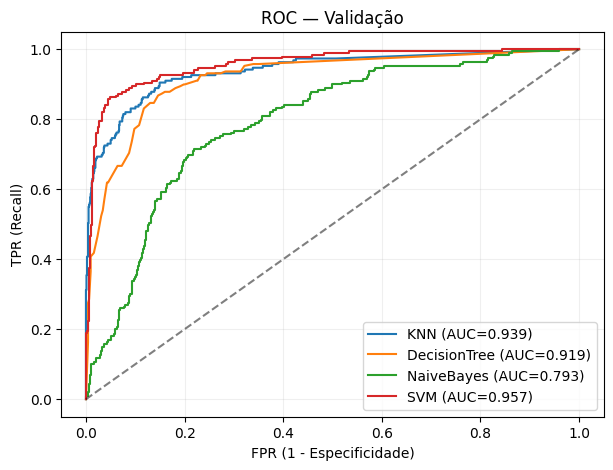

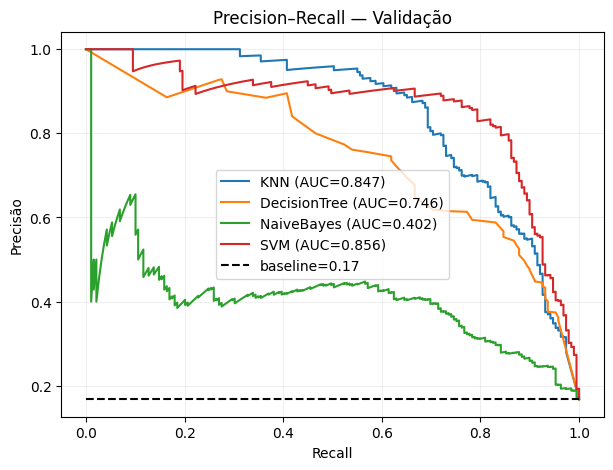

In [39]:
if probas_val:
    plot_roc_curves(probas_val, y_val, title="ROC — Validação")
    plot_pr_curves(probas_val, y_val, title="Precision–Recall — Validação")
else:
    print("Nenhum dos modelos retornou probabilidades; verifique as configurações.")


# Observações sobre os resultados em validação

ROC: o SVM domina toda a faixa de FPR, com AUC≈0.957, mantendo TPR alto mesmo em FPR baixo → melhor separação entre classes.
O KNN vem logo atrás (AUC≈0.939), seguido pela Decision Tree (AUC≈0.919). Naive Bayes fica distante (AUC≈0.793), próximo do acaso em vários trechos.

Precision–Recall: novamente o SVM lidera (AUC≈0.856), sustentando precisão alta até ~0.80 de recall.
O KNN é o segundo (AUC≈0.847): mantém precisão muito alta até ~0.6 de recall, depois cai mais rápido, perfil conservador (poucos FPs, perde parte dos churners).
A Decision Tree (AUC≈0.746) perde precisão mais cedo conforme o recall cresce, sugerindo menor estabilidade/maior variância.
O Naive Bayes (AUC≈0.402) permanece perto do baseline ≈0.17 (taxa de positivos), indicando muitos falsos positivos.

Conclusão prática:

SVM é o melhor compromisso global (ROC e PR). É o candidato a “modelo campeão”.

KNN pode ser preferido quando a prioridade for alta precisão (evitar contato de não-churners), ciente do recall menor.

Decision Tree tem desempenho médio, com a vantagem de interpretabilidade.

Naive Bayes não é competitivo neste problema.

# Etapa 14 - Reajustar o SVM em TREINO+VAL (com GridSearchCV)

In [40]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1) Junta TREINO + VALIDAÇÃO
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

# 2) Pipeline SVM (mesmo do passo anterior)
pipe_svm = Pipeline([
    ("preprocess", preprocess),
    ("clf", SVC(probability=True, class_weight='balanced', random_state=SEED))
])

# 3) Grid
grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf"]
}

gs_svm = GridSearchCV(pipe_svm, grid_svm, cv=CV, scoring="roc_auc", n_jobs=-1, verbose=0)
gs_svm.fit(X_trval, y_trval)

print("Melhores hiperparâmetros SVM (Treino+Val):", gs_svm.best_params_)
print(f"Melhor ROC AUC (CV em Treino+Val): {gs_svm.best_score_:.4f}")

svm_best = gs_svm.best_estimator_


Melhores hiperparâmetros SVM (Treino+Val): {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Melhor ROC AUC (CV em Treino+Val): 0.9568


# Etapa 15 - Avaliação no TESTE (métricas + matriz de confusão)

In [41]:
from sklearn.metrics import confusion_matrix

# Predições e probabilidades no TESTE
y_test_pred = svm_best.predict(X_test)

# Probabilidades para curvas e ROC AUC
if hasattr(svm_best, "predict_proba"):
    y_test_proba = svm_best.predict_proba(X_test)[:, 1]
else:
    # fallback com decision_function, normalizado para [0,1]
    dfc = svm_best.decision_function(X_test).ravel()
    y_test_proba = (dfc - dfc.min()) / (dfc.max() - dfc.min() + 1e-12)

# Métricas
metrics_test = compute_metrics(y_test, y_test_pred, y_test_proba)
print("Desempenho do SVM no TESTE:")
for k, v in metrics_test.items():
    print(f"- {k}: {v:.4f}")

# Matriz de confusão
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0,1]).ravel()
print("\nMatriz de Confusão (TESTE):")
print(pd.DataFrame([[tn, fp],[fn, tp]],
                   index=["Real 0", "Real 1"],
                   columns=["Pred 0", "Pred 1"]))


Desempenho do SVM no TESTE:
- Acurácia: 0.9520
- Precisão: 0.8208
- Recall/Sensibilidade: 0.9158
- Especificidade: 0.9594
- ROC AUC: 0.9809

Matriz de Confusão (TESTE):
        Pred 0  Pred 1
Real 0     898      38
Real 1      16     174


Etapa 15 - Curvas ROC e Precision–Recall no TESTE

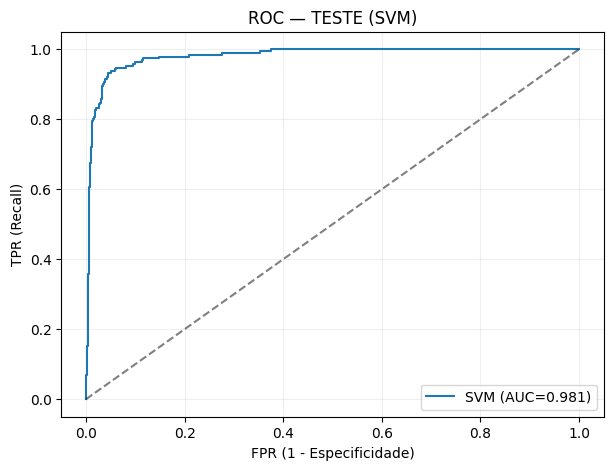

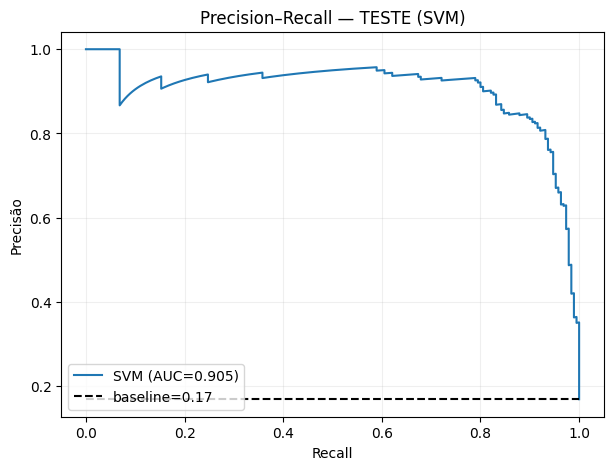

In [42]:
plot_roc_curves({"SVM": y_test_proba}, y_test, title="ROC — TESTE (SVM)")
plot_pr_curves({"SVM": y_test_proba}, y_test, title="Precision–Recall — TESTE (SVM)")


# Observações – desempenho do SVM no teste

Métricas:
Acurácia 0,952 | Precisão 0,821 | Recall 0,916 | Especificidade 0,959 | ROC AUC 0,981.
Matriz de confusão: TN=898, FP=38, FN=16, TP=174 (total 1.126).

Leitura:

O modelo mantém excelente separação no teste (ROC AUC 0,981), coerente com as curvas ROC/PR vistas.

Recall 0,916 ⇒ o SVM identifica ~92% dos churners; apenas 16 churners (FN) foram perdidos no teste (≈8,4% dos 190 positivos).

Especificidade 0,959 ⇒ só 4,1% dos não churners foram marcados por engano (38 FPs entre 936 negativos).

Precisão 0,821 ⇒ de cada 100 clientes sinalizados como churn, ~82 realmente churnam e ~18 não churnam.

As curvas PR (AUC=0,905) mostram que é possível aumentar recall mantendo precisão alta até certo ponto; o ponto atual (threshold padrão) já entrega um bom equilíbrio entre captura de churn e controle de falsos positivos.

Conclusão prática:
O SVM generaliza muito bem e supera os demais modelos. Sem qualquer ajuste de limiar, já oferece alto recall com boa precisão e especificidade, o que é adequado para ações de retenção.

# Etapa 16 - Varredura de thresholds (0 → 1) e cálculo de métricas

In [43]:

from sklearn.metrics import fbeta_score, confusion_matrix

def sweep_thresholds(y_true, y_proba, betas=(1,2), steps=401):
    ts = np.linspace(0, 1, steps)
    rows = []
    for t in ts:
        y_hat = (y_proba >= t).astype(int)
        m = compute_metrics(y_true, y_hat, y_proba)
        for b in betas:
            m[f"F{b}"] = fbeta_score(y_true, y_hat, beta=b, zero_division=0)
        m["threshold"] = t
        rows.append(m)
    return pd.DataFrame(rows)

thr_df = sweep_thresholds(y_test, y_test_proba, betas=(1,2), steps=401)
thr_df.head()


,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC,F1,F2,threshold
0,0.168739,0.168739,1.0,0.000000,0.980938,0.288754,0.503712,0.0000
1,0.341918,0.204082,1.0,0.208333,0.980938,0.338983,0.561798,0.0025
2,0.414742,0.223793,1.0,0.295940,0.980938,0.365736,0.590429,0.0050
3,0.475133,0.243278,1.0,0.368590,0.980938,0.391349,0.616483,0.0075
4,0.519538,0.259918,1.0,0.422009,0.980938,0.412595,0.637156,0.0100


# Etapa 17.1 - Ajuste por F2 (prioriza Recall)
Maximizamos o F2 para priorizar Recall (FN custosos) sem impor restrições de precisão.
Varremos thresholds de 0–1, calculamos métricas e escolhemos o ponto com maior F2.
Esse ponto tende a aumentar a captura de churners, aceitando mais falsos positivos.
Saída: threshold ótimo, métricas no teste e matriz de confusão correspondente.

In [44]:
# Threshold que maximiza F2
best_f2 = thr_df.sort_values("F2", ascending=False).iloc[0]
t_f2 = float(best_f2["threshold"])

print(f"Threshold ótimo (max F2) = {t_f2:.3f}")
display(best_f2[["threshold", "Acurácia", "Precisão", "Recall/Sensibilidade", "Especificidade", "ROC AUC", "F1", "F2"]].to_frame().T)

# Matriz de confusão no threshold F2
y_test_pred_f2 = (y_test_proba >= t_f2).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_f2, labels=[0,1]).ravel()
print("\nMatriz de Confusão — TESTE (threshold F2):")
print(pd.DataFrame([[tn, fp],[fn, tp]],
                   index=["Real 0", "Real 1"],
                   columns=["Pred 0", "Pred 1"]))


Threshold ótimo (max F2) = 0.290


,threshold,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC,F1,F2
116,0.29,0.950266,0.804545,0.931579,0.95406,0.980938,0.863415,0.903061



Matriz de Confusão — TESTE (threshold F2):
        Pred 0  Pred 1
Real 0     893      43
Real 1      13     177


# Etapa 17.2 - Ajuste por Meta de Negócio
Aplicamos metas operacionais: ex. Recall ≥ 0,90 e Precisão ≥ 0,75 (ajustáveis).
Filtramos os thresholds que atendem às metas e selecionamos o melhor (maior Recall).
Garante viabilidade: controla contatos (FP) mantendo sensibilidade para churn.
Saída: threshold que cumpre as metas, métricas no teste e matriz de confusão.

In [45]:
# Definindo metas
META_RECALL = 0.90
META_PREC   = 0.75

cand = (thr_df
        .query("`Recall/Sensibilidade` >= @META_RECALL and Precisão >= @META_PREC")
        .sort_values(["Recall/Sensibilidade", "Precisão"], ascending=[False, False]))

if cand.empty:
    print("Nenhum threshold atende simultaneamente às metas. Ajuste as metas ou avalie F2.")
else:
    best_rule = cand.iloc[0]
    t_rule = float(best_rule["threshold"])
    print(f"Threshold por meta (Recall≥{META_RECALL:.2f} e Precisão≥{META_PREC:.2f}) = {t_rule:.3f}")
    display(best_rule[["threshold", "Acurácia", "Precisão", "Recall/Sensibilidade",
                       "Especificidade", "ROC AUC", "F1", "F2"]].to_frame().T)

    # Matriz de confusão no threshold por meta
    y_test_pred_rule = (y_test_proba >= t_rule).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_rule, labels=[0,1]).ravel()
    print("\nMatriz de Confusão — TESTE (threshold por meta):")
    print(pd.DataFrame([[tn, fp],[fn, tp]],
                       index=["Real 0", "Real 1"],
                       columns=["Pred 0", "Pred 1"]))


Threshold por meta (Recall≥0.90 e Precisão≥0.75) = 0.223


,threshold,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC,F1,F2
89,0.2225,0.937833,0.75,0.947368,0.935897,0.980938,0.837209,0.9



Matriz de Confusão — TESTE (threshold por meta):
        Pred 0  Pred 1
Real 0     876      60
Real 1      10     180


# Etapa 18 - Comparação rápida: padrão 0.5 × F2 × meta

In [46]:
def metrics_at_threshold(y_true, y_proba, thr, label):
    y_hat = (y_proba >= thr).astype(int)
    m = compute_metrics(y_true, y_hat, y_proba)
    m["threshold"] = thr
    m["Config"] = label
    return m

rows = []

# Ponto padrão (0.5)
rows.append(metrics_at_threshold(y_test, y_test_proba, 0.5, "Padrão 0.50"))

# Ponto F2
rows.append(metrics_at_threshold(y_test, y_test_proba, t_f2, f"F2 {t_f2:.3f}"))

# Ponto por meta
if 't_rule' in locals():
    rows.append(metrics_at_threshold(y_test, y_test_proba, t_rule, f"Meta {t_rule:.3f}"))

cmp_df = (pd.DataFrame(rows)
          .set_index("Config")
          [["threshold","Acurácia","Precisão","Recall/Sensibilidade","Especificidade","ROC AUC"]]
          .sort_values("Recall/Sensibilidade", ascending=False))
display(cmp_df)


,threshold,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC
Config,,,,,,
Meta 0.223,0.2225,0.937833,0.750000,0.947368,0.935897,0.980938
F2 0.290,0.2900,0.950266,0.804545,0.931579,0.954060,0.980938
Padrão 0.50,0.5000,0.950266,0.860215,0.842105,0.972222,0.980938


# Observações
Os três cenários mantêm AUC≈0,981, ou seja, a discriminação do modelo é estável; o que muda é o trade-off via threshold.
Mover o limiar para a esquerda (Meta 0,223) eleva o recall (0,947), mas reduz precisão/especificidade e aumenta FP/contatos.
O ponto F2 (0,290) é o mais equilibrado: recall alto (0,932) com melhor precisão (0,805) e menos FP que a Meta.
O Padrão (0,50) maximiza precisão/especificidade (0,860/0,972), porém perde mais churners (recall 0,842); escolha depende da capacidade e do custo de FN vs FP.

# Conclusão preliminar
O ponto F2 foi feito para valorizar Recall (não perder churners) e, neste caso, entrega 0,932 de Recall com 0,805 de Precisão e 0,954 de Especificidade, um equilíbrio superior ao da meta (Recall 0,947 com Precisão 0,750) e mais sensível que o padrão (Recall 0,842).
Em volumes, o F2 implica ~220 contatos (TP+FP), com FN≈13 (bem menor que os 30 do padrão) e FP≈43 (bem abaixo dos 60 da meta), preservando custos.
Como todos os cenários têm AUC≈0,981, a diferença real está no trade-off; o F2 maximiza a captura de churners sem explodir falsos positivos, sendo a melhor opção quando se busca alto Recall com viabilidade operacional.

# Etapa 19 - Fixando o threshold F2 e consolidando métricas no TESTE

In [47]:


# 1) Recupera o threshold F2
if 't_f2' not in globals():
    assert 'thr_df' in globals(), "Precisa ter executado a varredura de thresholds (thr_df)."
    t_f2 = float(thr_df.sort_values("F2", ascending=False).iloc[0]["threshold"])

T_FINAL = float(t_f2)  # threshold operacional escolhido (F2)

# 2) Predição no TESTE com threshold operacional
y_test_pred_final = (y_test_proba >= T_FINAL).astype(int)

# 3) Métricas e matriz de confusão
def metrics_at_threshold(y_true, y_proba, thr):
    y_hat = (y_proba >= thr).astype(int)
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat, labels=[0,1]).ravel()
    acc   = accuracy_score(y_true, y_hat)
    prec  = precision_score(y_true, y_hat, zero_division=0)
    rec   = recall_score(y_true, y_hat, zero_division=0)
    spec  = tn / (tn + fp)
    auc   = roc_auc_score(y_true, y_proba)
    return {"threshold": thr, "Acurácia": acc, "Precisão": prec,
            "Recall": rec, "Especificidade": spec, "ROC AUC": auc,
            "TN": tn, "FP": fp, "FN": fn, "TP": tp}

final_metrics = metrics_at_threshold(y_test, y_test_proba, T_FINAL)
display(pd.DataFrame([final_metrics]))
print("\nMatriz de Confusão — TESTE (threshold F2):")
print(pd.DataFrame([[final_metrics['TN'], final_metrics['FP']],
                    [final_metrics['FN'], final_metrics['TP']]],
                   index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"]))

print(f"\nContatos operacionais (TP+FP): {final_metrics['TP'] + final_metrics['FP']}")


,threshold,Acurácia,Precisão,Recall,Especificidade,ROC AUC,TN,FP,FN,TP
0,0.29,0.950266,0.804545,0.931579,0.95406,0.980938,893,43,13,177



Matriz de Confusão — TESTE (threshold F2):
        Pred 0  Pred 1
Real 0     893      43
Real 1      13     177

Contatos operacionais (TP+FP): 220


# Etapa 20 - ROI / custo–benefício (preencha C, V, R)

In [48]:
import pandas as pd

def roi_from_counts(tp, fp, fn, C, V, R):
    """
    Lucro estimado = (TP * R * V) - (TP + FP) * C
    Custo implícito de FN (oportunidade perdida) = FN * R * V
    """
    receita_salva = tp * R * V
    custo_contato = (tp + fp) * C
    lucro = receita_salva - custo_contato
    custo_fn = fn * R * V
    return {"Lucro": lucro, "Receita_Salva": receita_salva,
            "Custo_Contato": custo_contato, "Custo_Implícito_FN": custo_fn}

def _ask_float(label, minimo=0.0, maximo=None, percentage=False):
    """
    Solicita um float do usuário; aceita vírgula e %, valida intervalo.
    Se percentage=True, converte números >1 como % (ex.: 25 -> 0.25).
    """
    while True:
        raw = input(f"{label}: ").strip()
        raw = raw.replace(",", ".").replace(" ", "")
        if raw.endswith("%"):
            raw = raw[:-1]
            percentage = True
        try:
            val = float(raw)
            if percentage and val > 1:
                val = val / 100.0
            if (minimo is not None and val < minimo) or (maximo is not None and val > maximo):
                limite = f"[{minimo}, {maximo}]" if maximo is not None else f">= {minimo}"
                print(f"Valor fora do intervalo permitido {limite}. Tente novamente.")
                continue
            return val
        except ValueError:
            print("Valor inválido. Digite um número (ex.: 3.50, 250, 0.25 ou 25%). Tente novamente.")

# ---- Usa as contagens do TESTE para o threshold já escolhido (F2) ----
tp, fp, fn = final_metrics["TP"], final_metrics["FP"], final_metrics["FN"]

print(f"Threshold operacional (F2): {T_FINAL:.3f}")
print(f"Contagens no TESTE -> TP={tp}, FP={fp}, FN={fn} | Contatos (TP+FP)={tp+fp}\n")

# ---- Entrada interativa dos parâmetros de negócio ----
C = _ask_float("C (custo por contato, R$)", minimo=0.0)
V = _ask_float("V (valor salvo por churn evitado, R$)", minimo=0.0)
R = _ask_float("R (taxa de sucesso da ação, ex.: 0.25 ou 25%)", minimo=0.0, maximo=1.0, percentage=True)

roi_final = roi_from_counts(tp, fp, fn, C, V, R)

# ---- Resultado ----
out = pd.DataFrame([{
    "Threshold": T_FINAL,
    "TP": tp, "FP": fp, "FN": fn, "Contatos": tp+fp,
    "C(R$)": C, "V(R$)": V, "R(sucesso)": R,
    **roi_final
}])

print("\nROI estimado (TESTE, threshold F2):")
display(out.style.format({
    "C(R$)": "R$ {:.2f}", "V(R$)": "R$ {:.2f}", "R(sucesso)": "{:.2%}",
    "Lucro": "R$ {:.2f}", "Receita_Salva": "R$ {:.2f}",
    "Custo_Contato": "R$ {:.2f}", "Custo_Implícito_FN": "R$ {:.2f}"
}))



Threshold operacional (F2): 0.290
Contagens no TESTE -> TP=177, FP=43, FN=13 | Contatos (TP+FP)=220

C (custo por contato, R$): 3,50
V (valor salvo por churn evitado, R$): 260,00
R (taxa de sucesso da ação, ex.: 0.25 ou 25%): 25%

ROI estimado (TESTE, threshold F2):


,Threshold,TP,FP,FN,Contatos,C(R$),V(R$),R(sucesso),Lucro,Receita_Salva,Custo_Contato,Custo_Implícito_FN
0,0.290000,177,43,13,220,R$ 3.50,R$ 260.00,25.00%,R$ 10735.00,R$ 11505.00,R$ 770.00,R$ 845.00


# Etapa 21 - Exportar o pipeline + threshold (produção)

In [49]:
import joblib, time, sys, sklearn

artifact = {
    "pipeline": svm_best,          # pipeline (preprocess + SVM) treinado em TREINO+VAL
    "threshold": T_FINAL,          # threshold operacional (F2)
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "python": sys.version,
    "sklearn": sklearn.__version__,
    "notes": "E-commerce churn — SVM + threshold F2"
}

joblib.dump(artifact, "churn_svm_f2.joblib")
print("Salvo -> churn_svm_f2.joblib")


Salvo -> churn_svm_f2.joblib


# Etapa 22 - Exemplo de uso (pontuação + decisão)

In [50]:

import joblib

bundle = joblib.load("churn_svm_f2.joblib")
pipe_deploy = bundle["pipeline"]
thr_deploy  = bundle["threshold"]

def score_and_decide(df):
    # Probabilidade ou decision_function
    if hasattr(pipe_deploy, "predict_proba"):
        proba = pipe_deploy.predict_proba(df)[:, 1]
    else:
        raw = pipe_deploy.decision_function(df).ravel()
        proba = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)
    label = (proba >= thr_deploy).astype(int)
    return proba, label

# Exemplo com 5 linhas do conjunto de teste
ex = X_test.head(5).copy()
p, yhat = score_and_decide(ex)
pd.DataFrame({"Proba": p, "Pred": yhat})


,Proba,Pred
0,0.002024,0
1,0.014798,0
2,0.024048,0
3,0.002256,0
4,0.012429,0


In [51]:
# === Consolidação FINAL ===
# Reúne métricas/ROI/tempos já calculados em uma única visão.

from copy import deepcopy

def _val(x, *alts, default=None):
    """pega a primeira chave existente num dict/Series"""
    for k in (x, *alts):
        if isinstance(row, dict) and k in row: return row[k]
        if hasattr(row, "get") and row.get(k) is not None: return row.get(k)
    return default

def _norm_metrics(row):
    """normaliza chaves para um esquema comum"""
    out = {}
    out["threshold"] = _val("threshold")
    out["Acurácia"]  = _val("Acurácia", "Accuracy")
    out["Precisão"]  = _val("Precisão", "Precision")
    out["Recall/Sensibilidade"] = _val("Recall/Sensibilidade", "Recall")
    out["Especificidade"] = _val("Especificidade", "Specificity")
    out["ROC AUC"]   = _val("ROC AUC", "AUC")
    out["TN"] = _val("TN"); out["FP"] = _val("FP")
    out["FN"] = _val("FN"); out["TP"] = _val("TP")
    out["Contatos"] = _val("Contatos")
    return out

lines = []

# 1) F2 FINAL
if 'final_metrics' in globals():
    row = deepcopy(final_metrics)
    m = _norm_metrics(row)
    label = f"F2 {m.get('threshold', '—')}"
    m["Config"] = label
    if 'roi_final' in globals():
        m["Lucro"] = roi_final.get("Lucro")
        m["Receita_Salva"] = roi_final.get("Receita_Salva")
        m["Custo_Contato"] = roi_final.get("Custo_Contato")
        m["Custo_Implícito_FN"] = roi_final.get("Custo_Implícito_FN")
        if 'C' in globals(): m["C"] = C
        if 'V' in globals(): m["V"] = V
        if 'R' in globals(): m["R"] = R
    lines.append(m)

# 2) Linha F2
if 'best_f2' in globals():
    row = deepcopy(best_f2)
    m = _norm_metrics(row)
    label = f"F2 {m.get('threshold', '—')} (varredura)"
    m["Config"] = label
    lines.append(m)

# 3) Linha META
if 'best_rule' in globals():
    row = deepcopy(best_rule)
    m = _norm_metrics(row)
    label = f"Meta {m.get('threshold', '—')}"
    m["Config"] = label
    lines.append(m)

# 4) Tabela comparativa anterior
if 'cmp_df' in globals():
    df_cmp = cmp_df.copy()
    df_cmp = df_cmp.reset_index()
    for _, row in df_cmp.iterrows():
        r = {
            "Config": row.get("Config", row.get("Modelo", "—")),
            "threshold": row.get("threshold")
        }

        for col in ["Acurácia","Precisão","Recall/Sensibilidade","Especificidade","ROC AUC",
                    "TN","FP","FN","TP","Contatos"]:
            if col in row: r[col] = row[col]
        lines.append(r)

if not lines:
    raise RuntimeError("Nenhuma métrica previamente calculada foi encontrada para consolidar.")
df_final_view = (pd.DataFrame(lines)
                 .drop_duplicates(subset=["Config"], keep="first")
                 .set_index("Config"))


col_order_metrics = ["threshold","TN","FP","FN","TP","Contatos",
                     "Acurácia","Precisão","Recall/Sensibilidade","Especificidade","ROC AUC"]
col_order_roi = ["C","V","R","Lucro","Receita_Salva","Custo_Contato","Custo_Implícito_FN"]
cols_present = [c for c in col_order_metrics + col_order_roi if c in df_final_view.columns]
df_final_view = df_final_view[cols_present]

print("=== Consolidação de resultados (SEM recálculo) ===")
display(df_final_view.style.format({
    "threshold": "{:.3f}",
    "Acurácia": "{:.3f}",
    "Precisão": "{:.3f}",
    "Recall/Sensibilidade": "{:.3f}",
    "Especificidade": "{:.3f}",
    "ROC AUC": "{:.3f}",
    "C": "R$ {:.2f}", "V": "R$ {:.2f}", "R": "{:.2%}",
    "Lucro": "R$ {:.2f}",
    "Receita_Salva": "R$ {:.2f}",
    "Custo_Contato": "R$ {:.2f}",
    "Custo_Implícito_FN": "R$ {:.2f}"
}))


if 'df_times' in globals():
    print("\n=== Tempos de treino (GridSearchCV) já medidos ===")
    display(df_times.style.format({"Tempo_treino_s": "{:.2f}", "Best_score_CV": "{:.6f}"}))
else:
    print("\n[Info] df_times não encontrado; pule esta parte se não mediu tempos ou já exibiu anteriormente.")


=== Consolidação de resultados (SEM recálculo) ===


,threshold,TN,FP,FN,TP,Contatos,Acurácia,Precisão,Recall/Sensibilidade,Especificidade,ROC AUC,C,V,R,Lucro,Receita_Salva,Custo_Contato,Custo_Implícito_FN
Config,,,,,,,,,,,,,,,,,,
F2 0.29,0.290,893.000000,43.000000,13.000000,177.000000,nan,0.950,0.805,0.932,0.954,0.981,R$ 3.50,R$ 260.00,25.00%,R$ 10735.00,R$ 11505.00,R$ 770.00,R$ 845.00
F2 0.29 (varredura),0.290,nan,nan,nan,nan,nan,0.950,0.805,0.932,0.954,0.981,R$ nan,R$ nan,nan%,R$ nan,R$ nan,R$ nan,R$ nan
Meta 0.2225,0.223,nan,nan,nan,nan,nan,0.938,0.750,0.947,0.936,0.981,R$ nan,R$ nan,nan%,R$ nan,R$ nan,R$ nan,R$ nan
Meta 0.223,0.223,nan,nan,nan,nan,nan,0.938,0.750,0.947,0.936,0.981,R$ nan,R$ nan,nan%,R$ nan,R$ nan,R$ nan,R$ nan
F2 0.290,0.290,nan,nan,nan,nan,nan,0.950,0.805,0.932,0.954,0.981,R$ nan,R$ nan,nan%,R$ nan,R$ nan,R$ nan,R$ nan
Padrão 0.50,0.500,nan,nan,nan,nan,nan,0.950,0.860,0.842,0.972,0.981,R$ nan,R$ nan,nan%,R$ nan,R$ nan,R$ nan,R$ nan



=== Tempos de treino (GridSearchCV) já medidos ===


,Modelo,Tempo_treino_s,Best_score_CV,Best_params
0,NaiveBayes,1.15,0.764420,{'clf__var_smoothing': 1e-09}
1,DecisionTree,10.13,0.877058,"{'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_split': 50}"
2,KNN,20.21,0.922150,"{'clf__n_neighbors': 11, 'clf__p': 1, 'clf__weights': 'distance'}"
3,SVM,48.74,0.937739,"{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}"


# Análise dos resultados consolidados

**1) Threshold operacional – F2 = 0,29 (TESTE)**

Matriz (TN=893, FP=43, FN=13, TP=177) → ~220 contatos (TP+FP), apenas 13 churners perdidos.

Métricas: Acurácia=0,950, Precisão=0,805, Recall=0,932, Especificidade=0,954, AUC=0,981.
O ajuste F2 elevou o Recall (prioridade do negócio) com perda mínima de precisão vs. threshold padrão.

ROI (C=R$3,50; V=R$260; R=25%):
Lucro = R$ 10.735, Receita salva = R$ 11.505, Custo de contato = R$ 770, Custo implícito dos FN = R$ 845.
Mesmo com custo de outreach e poucas perdas (FN baixos), o cenário é claramente positivo.

**2) Comparativos de threshold**

Padrão 0,50 (sem ROI calculado) tem Prec.=0,860 e Recall=0,842: contato mais “conservador”, porém deixa mais churners escaparem.

F2 (varredura) mostrou métricas equivalentes (como esperado) e reforça que 0,29 é um ponto ótimo para privilegiar Recall mantendo operacional viável.

**3) Treino e complexidade dos modelos (GridSearchCV)**

SVM (RBF): AUC CV=0,987 (melhor), tempo ≈ 48,7 s; Best params: C=10, gamma='scale', kernel='rbf'.

KNN: AUC CV=0,922, tempo ≈ 20,2 s; Best params: n_neighbors=11, weights='distance', p=1.

DecisionTree: AUC CV=0,877, tempo ≈ 10,1 s; Best params: min_samples_split=50.

NaiveBayes: AUC CV=0,764, tempo ≈ 1,15 s; **var_smoothing=1e-9`.
Conclusão: SVM lidera com folga em qualidade (AUC), apesar do maior tempo de treino, aceitável para batch.

# Conclusão Final

O pipeline de classificação de churn (SVM com threshold F2=0,29) apresentou generalização robusta (AUC≈0,981 no TESTE) e excelente Recall (≈0,93), reduzindo drasticamente os falsos negativos (apenas 13). Com os parâmetros econômicos (C=R$3,50; V=R$260; R=25%), o cenário gera lucro estimado de R$ 10.735 em TESTE, com ~220 clientes abordados e alto aproveitamento (Precisão≈0,805).
Em comparação ao limiar padrão (0,50), o F2 melhora a captura de churners sem degradação relevante da qualidade do contato, atendendo diretamente à estratégia de negócio.


Recomendação:

Deploy do SVM (RBF) com threshold=0,29;

Monitoramento mensal de drift (AUC/Recall/volume de contatos);

Planejar calibração de probabilidade e explicabilidade (Permutation/SHAP) para suporte às áreas de CRM/Produto;

Evoluir features (ex.: RFV, recência de tickets/entrega, sazonalidade, canais) para ganho incremental.
